In [1]:
import tensornetwork as tn
import ocr_data

import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [] #[(5,5)] #[(3,3),(3,3),(3,3),(3,3),(3,3)]
conv_stride = [] #[(3,3)] #[(1,1),(2,2),(1,1),(2,2),(1,1)]
conv_outs = [] #[(4,)] #[(4,),(8,),(8,),(16,),(16,)]
conv_layers = len(conv_kernels)
hidden_shapes = []
hidden_layers = len(hidden_shapes)
recurrent_layers = 2
recurrent_size = 20
residual_layers = 0
more_hidden_shapes = []
more_hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
in_layer = tn.Input(input_shape)()
last_layer = in_layer
print(in_layer)
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    last_layer = tn.Conv(kernel_shape,out_shape=out_shape,kernel_stride=kernel_stride,pad=True,activation=tn.ReLU())(last_layer)
    print(last_layer)
for hidden_shape in hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.ReLU())(last_layer)
    print(last_layer)
for i in range(recurrent_layers):
    last_layer = tn.LSTM(recurrent_size,activation=tn.Tanh())(last_layer)
    print(last_layer)
for i in range(residual_layers):
    last_layer = tn.ResWrap(tn.Dense(last_layer.output_shapes[0],activation=tn.ReLU()))(last_layer)
    print(last_layer)
for hidden_shape in more_hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.ReLU())(last_layer)
    print(last_layer)
out_layer = tn.Dense(output_shape,activation=tn.Sigmoid())(last_layer)
print(out_layer)

s = tn.System(inputs=[in_layer],outputs=[out_layer])

Input :: [] -> [(32, 32)]
Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)]
Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)]
Dense :: [(32, 20)] -> [(26,)]
Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)] idx: 1 => Dense :: [(32, 20)] -> [(26,)] idx: 0
Join :: [(20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,)] -> [(32, 20)] idx: 2 => Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)] idx: 1
Mul :: [(20,), (20,)] -> [(20,)] idx: 3 => Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)] idx: 1
Add :: [(20,), (20,)] -> [(20,)] idx: 4 => Combine :: [(32, 20), (20,), (20,)] -> [(32, 20), (20,), (20,)] idx: 1
Mul :: [(20,), (20,)] -> [(20,)] idx: 5 => Join :: [(20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,

Add :: [(20,), (20,)] -> [(20,)] idx: 149 => Activate :: [(20,)] -> [(20,)] idx: 84
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 150 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 85
Add :: [(20,), (20,)] -> [(20,)] idx: 151 => Activate :: [(20,)] -> [(20,)] idx: 86
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 152 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 87
Add :: [(20,), (20,)] -> [(20,)] idx: 153 => Activate :: [(20,)] -> [(20,)] idx: 88
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 154 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 89
Add :: [(20,), (20,)] -> [(20,)] idx: 155 => Activate :: [(20,)] -> [(20,)] idx: 90
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 156 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 91
Add :: [(20,), (20,)] -> [(20,)] idx: 157 => Activate :: [(20,)] -> [(20,)] idx: 92
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 158 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 93
Add :: [(20,), (20,)] -> [(20,)] idx: 159 => Activate :: [(20,)] -> [(20,)] idx: 94
FlatConcat :: [(20,),

Clone(Dense) :: [(40,)] -> [(20,)] idx: 242 => Mul :: [(20,), (20,)] -> [(20,)] idx: 188
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 124 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 189
Add :: [(20,), (20,)] -> [(20,)] idx: 123 => Mul :: [(20,), (20,)] -> [(20,)] idx: 190
Clone(Dense) :: [(40,)] -> [(20,)] idx: 243 => Mul :: [(20,), (20,)] -> [(20,)] idx: 190
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 126 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 191
Add :: [(20,), (20,)] -> [(20,)] idx: 125 => Mul :: [(20,), (20,)] -> [(20,)] idx: 192
Clone(Dense) :: [(40,)] -> [(20,)] idx: 244 => Mul :: [(20,), (20,)] -> [(20,)] idx: 192
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 128 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 193
Add :: [(20,), (20,)] -> [(20,)] idx: 127 => Mul :: [(20,), (20,)] -> [(20,)] idx: 194
Clone(Dense) :: [(40,)] -> [(20,)] idx: 245 => Mul :: [(20,), (20,)] -> [(20,)] idx: 194
FlatConcat :: [(20,), (20,)] -> [(40,)] idx: 130 => Clone(Dense) :: [(40,)] -> [(20,)] idx: 195

Add :: [(20,), (20,)] -> [(20,)] idx: 364 => Mul :: [(20,), (20,)] -> [(20,)] idx: 299
Clone(Dense) :: [(52,)] -> [(20,)] idx: 365 => Mul :: [(20,), (20,)] -> [(20,)] idx: 299
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 363 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 300
Add :: [(20,), (20,)] -> [(20,)] idx: 366 => Activate :: [(20,)] -> [(20,)] idx: 301
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 367 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 302
Add :: [(20,), (20,)] -> [(20,)] idx: 368 => Activate :: [(20,)] -> [(20,)] idx: 303
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 369 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 304
Add :: [(20,), (20,)] -> [(20,)] idx: 370 => Activate :: [(20,)] -> [(20,)] idx: 305
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 371 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 306
Add :: [(20,), (20,)] -> [(20,)] idx: 372 => Activate :: [(20,)] -> [(20,)] idx: 307
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 373 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 308
Add 

FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 369 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 434
Add :: [(20,), (20,)] -> [(20,)] idx: 368 => Mul :: [(20,), (20,)] -> [(20,)] idx: 435
Clone(Dense) :: [(52,)] -> [(20,)] idx: 496 => Mul :: [(20,), (20,)] -> [(20,)] idx: 435
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 371 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 436
Add :: [(20,), (20,)] -> [(20,)] idx: 370 => Mul :: [(20,), (20,)] -> [(20,)] idx: 437
Clone(Dense) :: [(52,)] -> [(20,)] idx: 497 => Mul :: [(20,), (20,)] -> [(20,)] idx: 437
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 373 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 438
Add :: [(20,), (20,)] -> [(20,)] idx: 372 => Mul :: [(20,), (20,)] -> [(20,)] idx: 439
Clone(Dense) :: [(52,)] -> [(20,)] idx: 498 => Mul :: [(20,), (20,)] -> [(20,)] idx: 439
FlatConcat :: [(20,), (32,)] -> [(52,)] idx: 375 => Clone(Dense) :: [(52,)] -> [(20,)] idx: 440
Add :: [(20,), (20,)] -> [(20,)] idx: 374 => Mul :: [(20,), (20,)] -> [(20,)] idx: 441
C

In [5]:
import multiprocessing
import functools

def batch(length=1000):    
    total,failures = 0,0
    state = None
    for true_out,input in ocr_data.tagged_2d_data(length):
        guess_out,state = s.guess([input],return_state=True)
        #print(guess_out[0]-true_out)
        if np.argmax(guess_out[0]) != np.argmax(true_out):
            failures += 1
        s.learn(state,[true_out],scale=1e-2,loss='quad')
        total += 1
    return total,failures

In [6]:
print('loading weights')
s.load_weights('OCR_lstm_network.h5')

loading weights


In [11]:
%prun batch(100)

In [8]:
try:
    batch_size = 100000
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_lstm_network.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

saving weights
batch accuracy 83536 / 100000
saving weights
batch accuracy 85940 / 100000
saving weights
batch accuracy 87848 / 100000
saving weights
batch accuracy 88381 / 100000
saving weights
batch accuracy 88632 / 100000
saving weights
batch accuracy 88748 / 100000
saving weights
batch accuracy 89178 / 100000
saving weights
batch accuracy 89532 / 100000
saving weights
batch accuracy 89467 / 100000
saving weights
batch accuracy 89610 / 100000
saving weights
batch accuracy 89624 / 100000
Stopped by user


neuron A


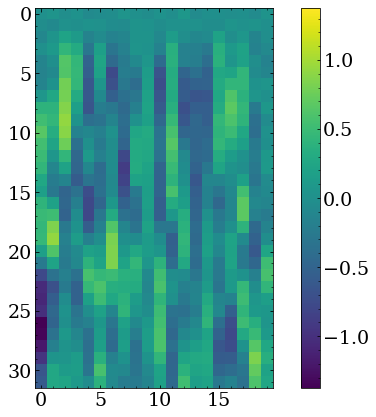

neuron B


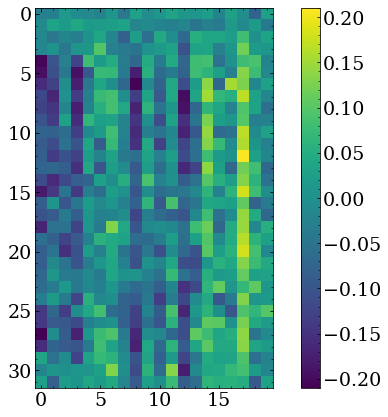

neuron C


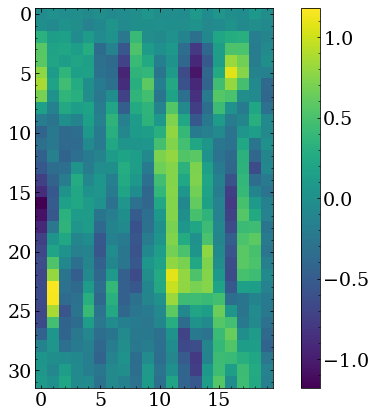

neuron D


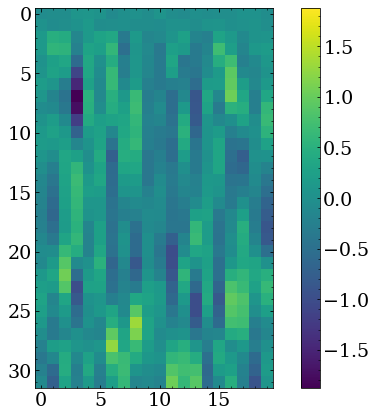

neuron E


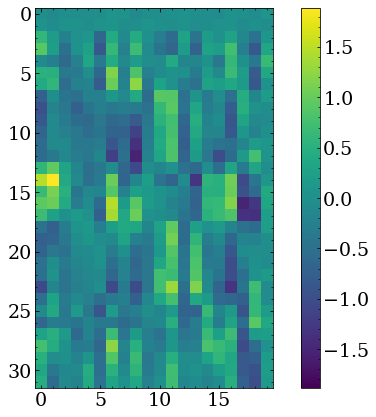

neuron F


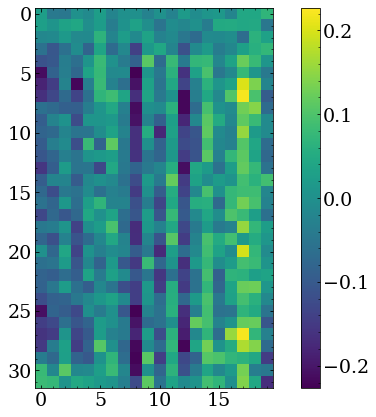

neuron G


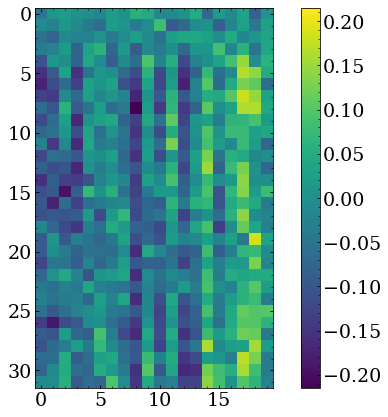

neuron H


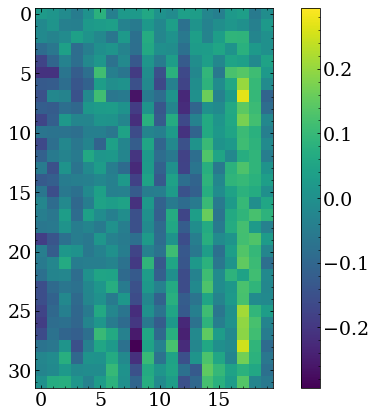

neuron I


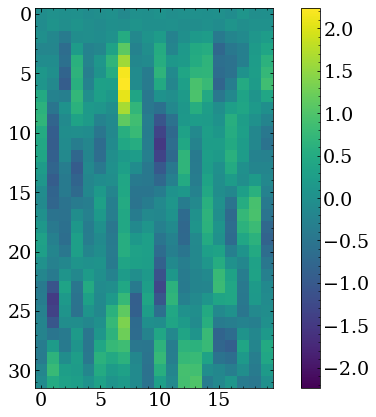

neuron J


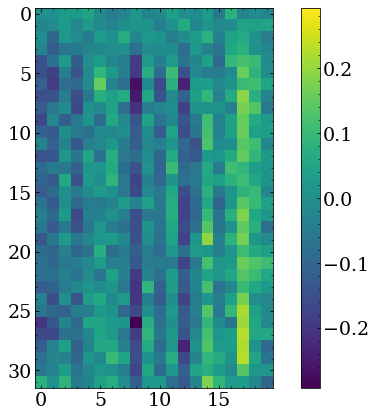

neuron K


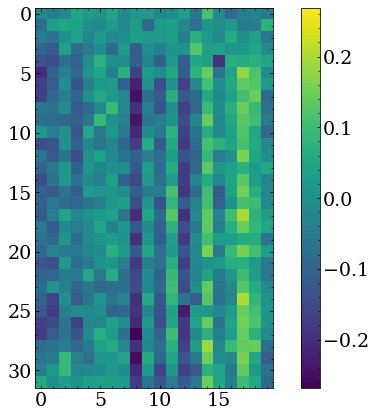

neuron L


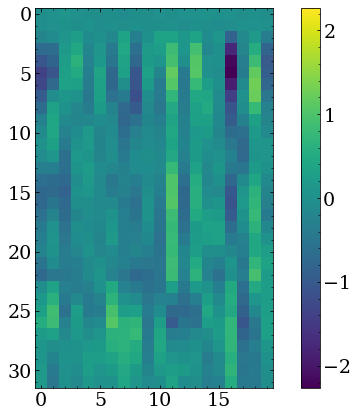

neuron M


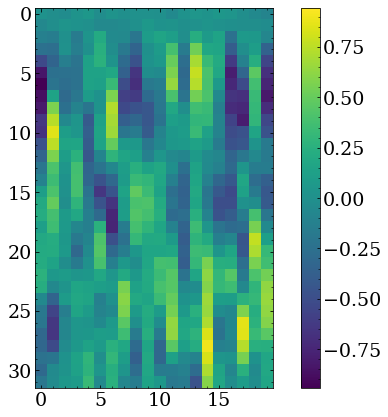

neuron N


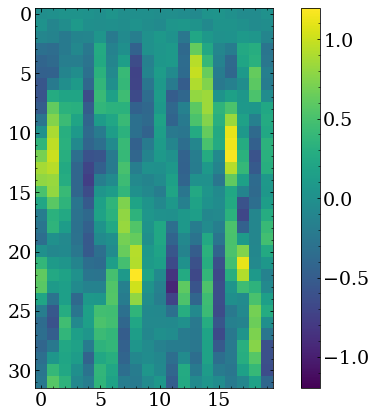

neuron O


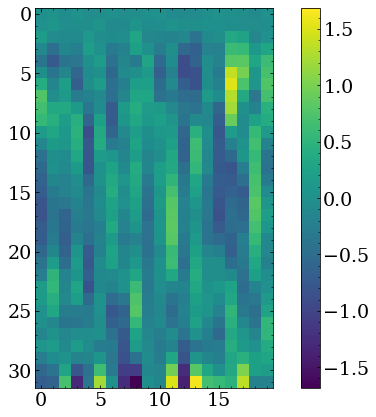

neuron P


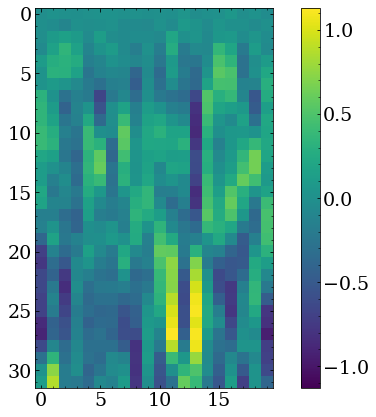

neuron Q


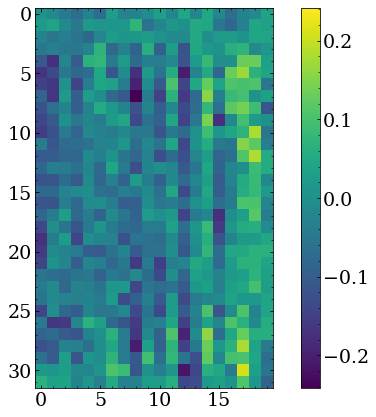

neuron R


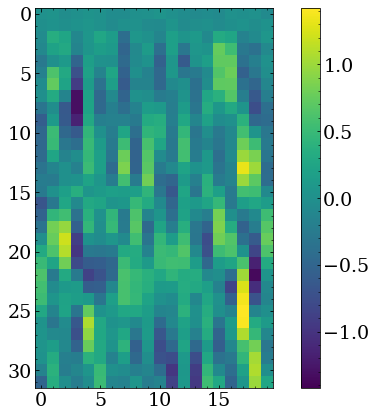

neuron S


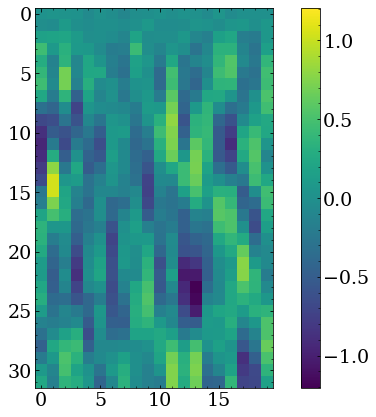

neuron T


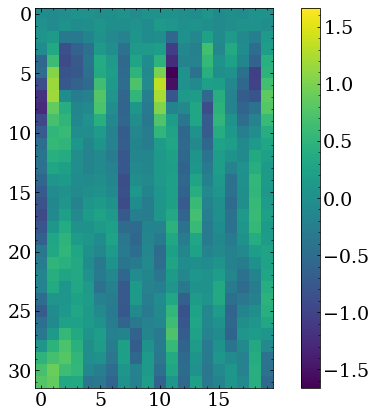

neuron U


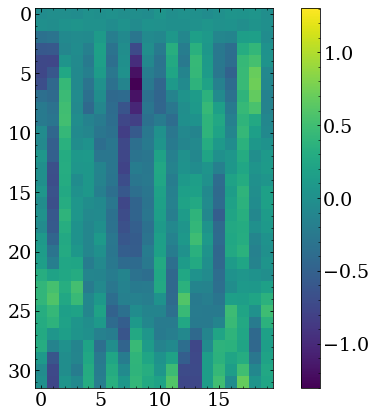

neuron V


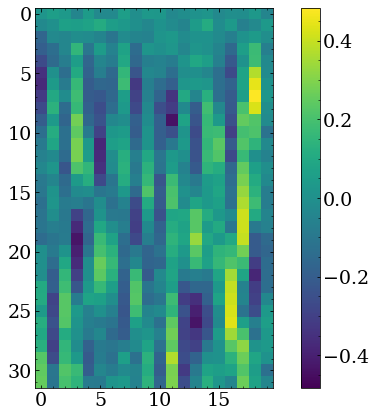

neuron W


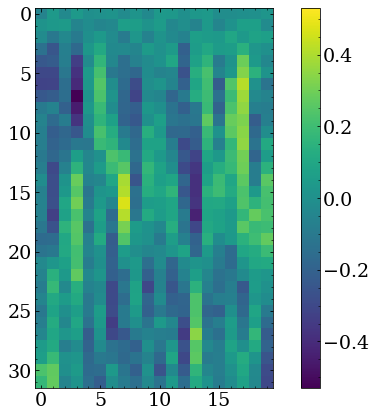

neuron X


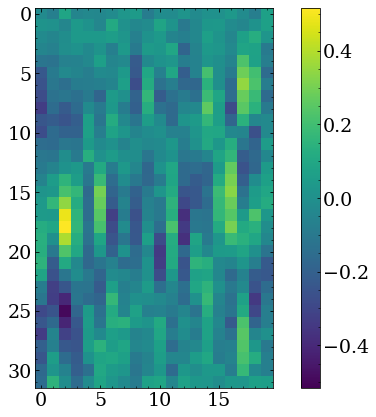

neuron Y


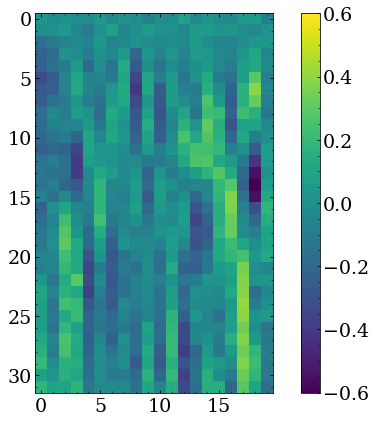

In [9]:
for i,c in enumerate(range(ord('A'),ord('Z'))):
    print('neuron',chr(c))
    data = s.parts[0].layer[0].weights[i,:].reshape((32,recurrent_size))
    norm = np.max(np.abs(data))
    plt.imshow(data,norm=matplotlib.colors.Normalize(-norm,norm))
    
    plt.colorbar()
    plt.show()
    plt.close()